In [1]:
import pandas as pd
import geopandas as gpd
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv ,SAGEConv,ChebConv,GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import haversine_distances
import torch.nn.functional as F
from torch.nn.functional import softmax

In [2]:
CUDA = True  # or False depending on your preference
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"

In [3]:
df = pd.read_csv("../data/processed/node_features.csv")
road_gdf = gpd.read_file("../data/processed/singapore_road_network.gpkg" , layer="edges")

Graph Construction

In [4]:
node_df = df.copy()
node_df = node_df.drop(columns=[col for col in node_df.columns if "Unnamed" in col])
node_df = node_df.dropna()

coords = node_df[['Latitude', 'Longitude']].to_numpy()
coords_rad = np.radians(coords)
distances = haversine_distances(coords_rad) * 6371000  # in meters

# Define connectivity threshold (in meters)
edge_index = np.array(np.where((distances > 0) & (distances < 1000)))
edge_attr = distances[edge_index[0], edge_index[1]]

# Node features
node_df = node_df.rename(columns={
    'Total Casualties Fatalities': 'Total_Casualties_Fatalities',
    'Pedestrians': 'Pedestrians',
    'Rainfall_mm': 'Rainfall',
    'Traffic_Volume': 'Traffic_Volume'
})

# Pick the clean features we can use
feature_cols = [
    'Rainfall',
    'Traffic_Volume',
    'Total_Casualties_Fatalities',
    'Pedestrians'
]
node_df.columns = node_df.columns.str.strip()
features = node_df[feature_cols].astype(float).to_numpy()
scaler = StandardScaler()
x = torch.tensor(scaler.fit_transform(features), dtype=torch.float)

# Binary labels: hotspot or not
threshold = node_df['Total_Casualties_Fatalities'].astype(float).median()
y = torch.tensor((node_df['Total_Casualties_Fatalities'].astype(float) > threshold).astype(int).values, dtype=torch.long)

data = Data(
    x=x,
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    edge_attr=torch.tensor(edge_attr, dtype=torch.float),
    y=y
)

In [5]:
print(node_df.columns.tolist())


['Latitude', 'Longitude', 'Date', 'Rainfall', 'Traffic_Volume', 'Total_Casualties_Fatalities', 'Pedestrians', 'Personal Mobility Device Users', 'Cyclists & Pillions', 'Motor Cyclists & Pillion Riders', 'Motor Cars And Station Wagons', 'Goods Vans & Pick-Ups', 'Goods Vans', 'Pick-Ups', 'Lorries, Tipper Trucks & Trailers', 'Lorries', 'Tipper Trucks', 'Trailers', 'Buses', 'Others', 'Total Casualties Injured', 'Pedestrians.1', 'Personal Mobility Device Users.1', 'Cyclists & Pillions.1', 'Motor Cyclists & Pillion Riders.1', 'Motor Cars And Station Wagons.1', 'Goods Vans & Pick-Ups.1', 'Goods Vans.1', 'Pick-Ups.1', 'Lorries, Tipper Trucks & Trailers.1', 'Lorries.1', 'Tipper Trucks.1', 'Trailers.1', 'Buses.1', 'Others.1', 'Total Casualties Fatalities_casualty', 'Pedestrians_casualty', 'Personal Mobility Device Users_casualty', 'Cyclists & Pillions_casualty', 'Motor Cyclists & Pillion Riders_casualty', 'Motor Cars And Station Wagons_casualty', 'Goods Vans & Pick-Ups_casualty', 'Goods Vans_casu

Train Test Validation Split

In [6]:
indices = np.arange(data.num_nodes)
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42, stratify=y)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, stratify=y[temp_idx])

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True


Define Models

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # Output single logit per node


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x
    
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
class ChebNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, hidden_channels, K=K)
        self.conv2 = ChebConv(hidden_channels, out_channels, K=K)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # Output single logit per node




model_configs = {
    "GCN": {
        "class": GCN,
        "params": {"hidden_channels": 16, "out_channels": 2},
        "lr": 0.005,
        "epochs": 100
    },
    "GAT": {
        "class": GAT,
        "params": {"hidden_channels": 16, "out_channels": 2, "heads": 2},
        "lr": 0.005,
        "epochs": 100
    },
    "GraphSAGE": {
        "class": GraphSAGE,
        "params": {"hidden_channels": 32, "out_channels": 2},
        "lr": 0.005,
        "epochs": 10
    },
    "ChebNet": {
        "class": ChebNet,
        "params": {"hidden_channels": 16, "out_channels": 2, "K": 3},
        "lr": 0.005,
        "epochs": 100
    }
}


Evaluator Function


In [8]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum().item()
        return correct / mask.sum().item()


Trainer function

In [ ]:
def train_model(name, config, data, patience=20):
    model = config["class"](in_channels=data.x.shape[1], **config["params"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    loss_fn = torch.nn.CrossEntropyLoss()
    
    val_accs = []
    losses = []

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(config["epochs"]):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        val_acc = evaluate(model, data, data.val_mask)
        val_accs.append(val_acc)

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"{name} Best Val Acc: {best_val_acc:.4f}")
    return model, losses, val_accs



trained_models = {}
results = {}

for model_name, cfg in model_configs.items():
    print(f"\nTraining {model_name}")
    model, losses, accs = train_model(model_name, cfg, data) 
    trained_models[model_name] = model                        
    results[model_name] = {"loss": losses, "acc": accs}


Training GCN
Early stopping at epoch 12
GCN Best Val Acc: 0.8182

Training GAT
Early stopping at epoch 13
GAT Best Val Acc: 0.7727

Training GraphSAGE
GraphSAGE Best Val Acc: 0.7727

Training ChebNet
Early stopping at epoch 12
ChebNet Best Val Acc: 0.4091


Evaluation on test set

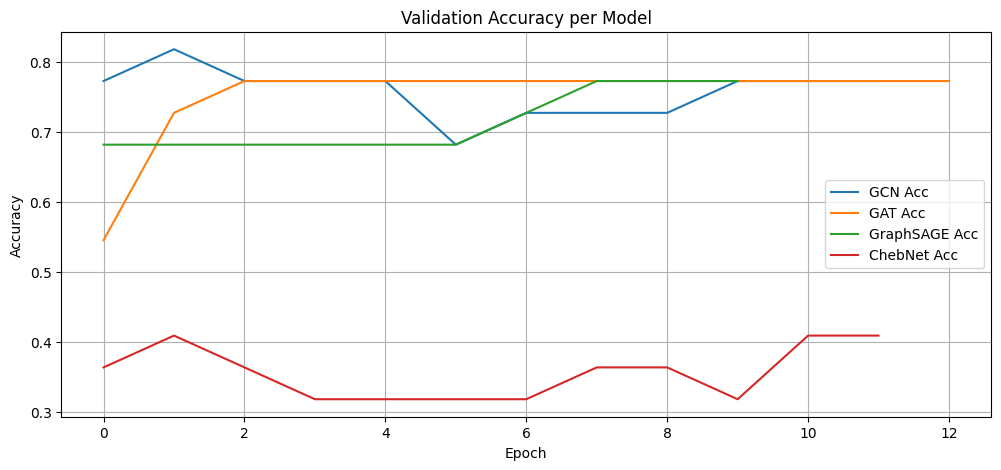

In [10]:
plt.figure(figsize=(12, 5))

# Accuracy
for name, res in results.items():
    plt.plot(res["acc"], label=f"{name} Acc")
plt.title("Validation Accuracy per Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Output

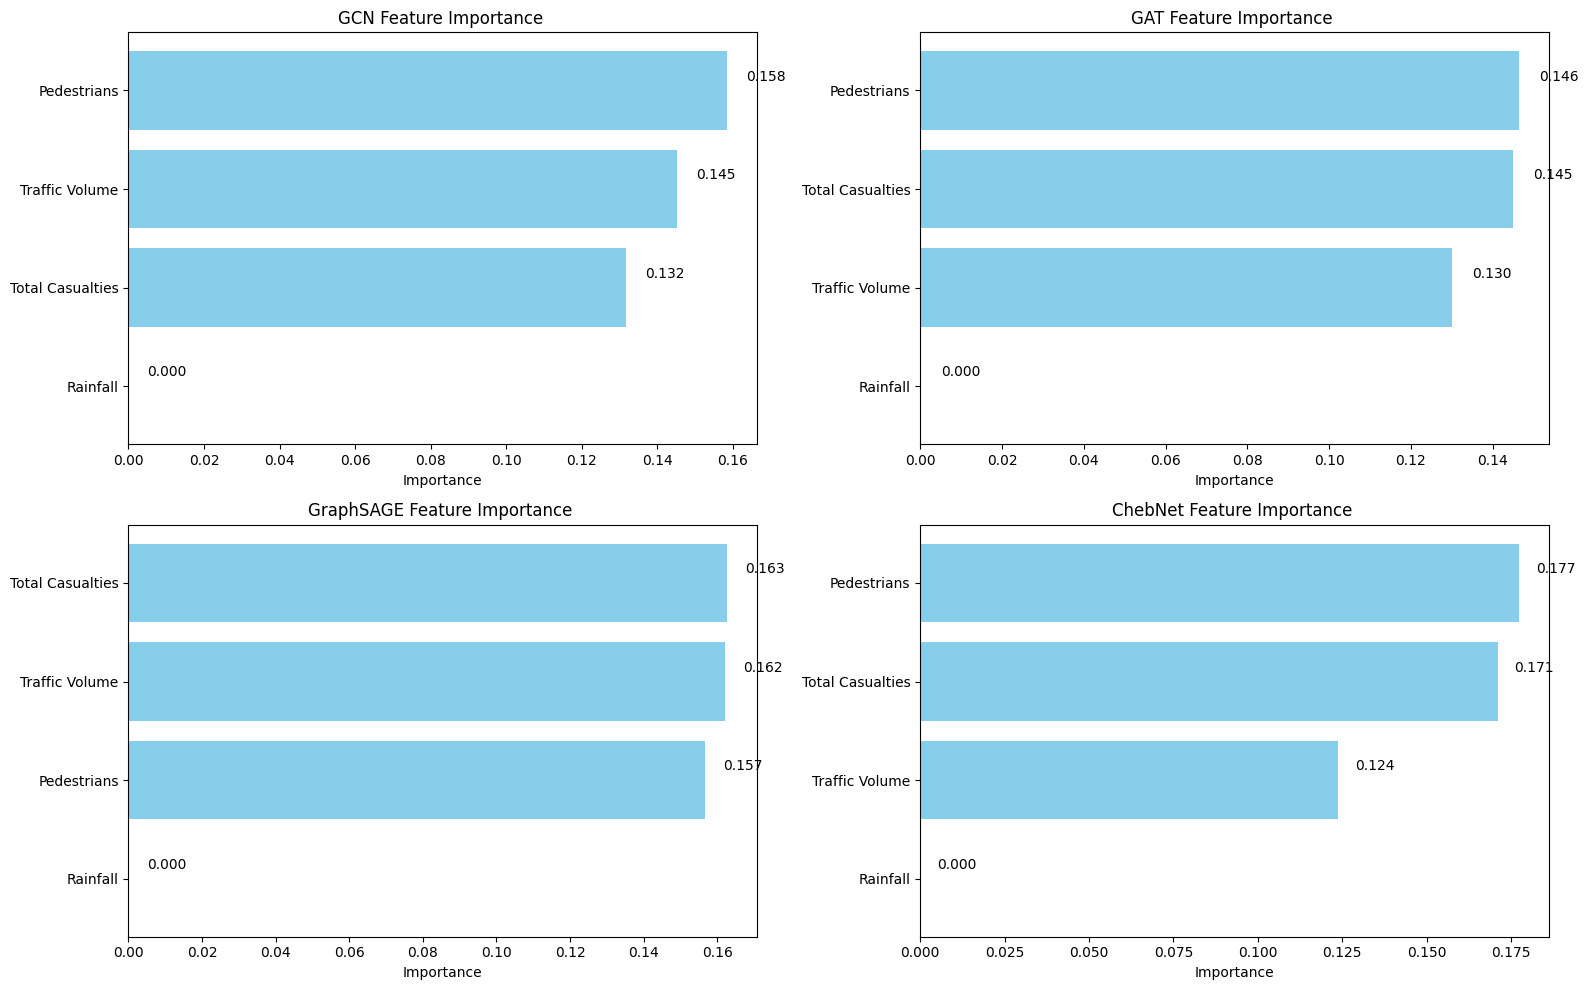

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ModelTaskLevel, ModelReturnType

# Feature labels
feature_labels = ['Rainfall', 'Traffic Volume', 'Total Casualties', 'Pedestrians']

# Node to explain
node_idx = int(data.val_mask.nonzero(as_tuple=True)[0][8])  # change index if needed

# Create subplot grid
plt.figure(figsize=(16, 10))

# Loop through each trained model
for i, (name, model) in enumerate(trained_models.items(), 1):
    # Setup explainer
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type="object",
        model_config=ModelConfig(
            mode=ModelMode.multiclass_classification,
            task_level=ModelTaskLevel.node,
            return_type=ModelReturnType.raw
        )
    )

    # Run explainer
    explanation = explainer(data.x, data.edge_index, index=node_idx)

    # Extract feature importance
    importance = explanation.node_mask.cpu().numpy().flatten()[:4]

    # Sort features
    indices = np.argsort(importance)[::-1]
    sorted_importance = importance[indices]
    sorted_labels = [feature_labels[j] for j in indices]

    # Plot
    plt.subplot(2, 2, i)
    bars = plt.barh(range(len(sorted_labels)), sorted_importance, color='skyblue')
    plt.yticks(range(len(sorted_labels)), sorted_labels)
    plt.gca().invert_yaxis()
    plt.xlabel("Importance")
    plt.title(f"{name} Feature Importance ")
    for j, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.005, bar.get_y() + 0.3, f"{sorted_importance[j]:.3f}")

plt.tight_layout()
plt.show()


In [12]:
# from torch_geometric.explain import Explainer, GNNExplainer
# from torch_geometric.explain.config import ModelConfig, ModelMode, ModelTaskLevel, ModelReturnType

# for name
# explainer = Explainer(
#     model=model,
#     algorithm=GNNExplainer(epochs=200),
#     explanation_type="model",
#     node_mask_type="attributes",
#     edge_mask_type="object",
#     model_config=ModelConfig(
#         mode=ModelMode.multiclass_classification,
#         task_level=ModelTaskLevel.node,
#         return_type=ModelReturnType.raw
#     )
# )

# # Pick a node from the validation set
# node_idx = int(data.val_mask.nonzero(as_tuple=True)[0][0])  # get first val node index

# # Generate explanation for that node
# explanation = explainer(data.x, data.edge_index, index=node_idx)

# # Visualize feature importance
# explanation.visualize_feature_importance()
# plt.title(f"Node {node_idx} Feature Importance")
# plt.show()

In [13]:
# from torch_geometric.explain.config import ModelReturnType
# print(list(ModelReturnType))


In [14]:
# from torch_geometric.explain import Explainer, GNNExplainer
# from torch_geometric.explain.config import ModelConfig, ModelMode, ModelTaskLevel, ModelReturnType

# explainer = Explainer(
#     model=model,
#     algorithm=GNNExplainer(epochs=200),
#     explanation_type="model",
#     node_mask_type="attributes",
#     edge_mask_type="object",
#     model_config=ModelConfig(
#         mode=ModelMode.multiclass_classification,      # ✅ use Enum
#         task_level=ModelTaskLevel.node,     # ✅ use Enum
#         return_type=ModelReturnType.raw  # ✅ use Enum
#     )
# )



In [15]:
# node_idx = int(val_idx[0])
# explanation = explainer(data.x, data.edge_index, index=node_idx)
# explanation.visualize_feature_importance()


In [16]:
# # 1. Pick node and explain
# node_idx = int(val_idx[0])
# explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)

# # 2. Get the global flat mask
# importance = explanation.node_mask.detach().cpu().numpy().flatten()

# # 3. Extract only the part for the current node
# num_features = 4
# start = node_idx * num_features
# end = start + num_features
# importance = importance[start:end]  # ✅ extract feature importance for the node

# # 4. Plotting
# feature_labels = ['Rainfall', 'Traffic Volume', 'Total Casualties', 'Pedestrians']
# indices = np.argsort(importance)[::-1]
# sorted_importance = importance[indices]
# sorted_labels = [feature_labels[int(i)] for i in indices]

# import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# bars = plt.barh(range(len(sorted_labels)), sorted_importance, color='skyblue')
# plt.yticks(range(len(sorted_labels)), sorted_labels)
# plt.gca().invert_yaxis()
# plt.xlabel("Importance")
# plt.title(f"Feature Importance for Node {node_idx}")
# for i, bar in enumerate(bars):
#     plt.text(bar.get_width() + 0.01, bar.get_y() + 0.3, f"{sorted_importance[i]:.3f}")
# plt.tight_layout()
# plt.show()


In [17]:
# print("importance shape:", importance.shape)
# print("importance:", importance)

# indices = np.argsort(importance)[::-1]
# print("sorted indices:", indices)
